In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
import pickle
import glob
import time
import cv2

from skimage.feature import hog
from utils import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
from tqdm import tqdm

%matplotlib inline

In [2]:
path2test_images = "./test_images/"
pattern = "*jpg"

path2cars = "./vehicles/"
path2not_cars = "./non-vehicles/"
pattern_train = "*png"

path2model = "trained_model.pkl"

### Exploring the dataset

In [3]:
test_images = glob.glob(path2test_images + pattern)
test_images

['./test_images/test2.jpg',
 './test_images/test1.jpg',
 './test_images/test5.jpg',
 './test_images/test6.jpg',
 './test_images/test3.jpg',
 './test_images/test4.jpg']

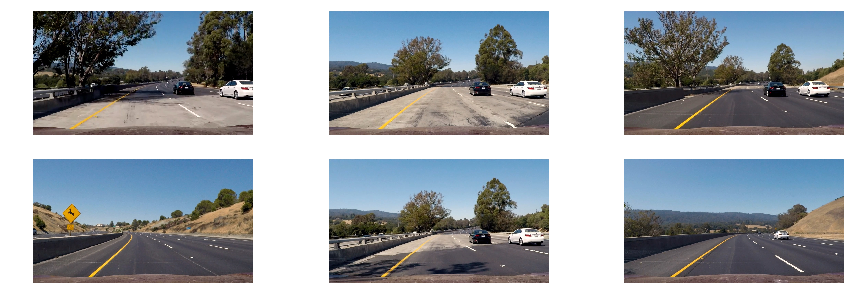

In [59]:
plt.figure(1, figsize=(15, 5))

i = 1

for image_name in test_images:
    img = cv2.imread(image_name)
    img = img[:,:, [2,1,0]]
    plt.subplot(2,3, i)
    plt.imshow(img)
    plt.axis('off')
    i += 1

Ok, these were the test images. Now is time to download the dataset for training

* Small dataset

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip

* Full dataset

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip && unzip vehicles.zip

!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip && unzip non-vehicles.zip

Note: the previous 2 cells were converted to Markdown cells to avoid accidental unwanted executions

What does the dataset look like?

In [60]:
cars = glob.glob(path2cars + "**/" + pattern_train, recursive=True)
not_cars = glob.glob(path2not_cars + "**/" + pattern_train, recursive=True)

Your dataset contains a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


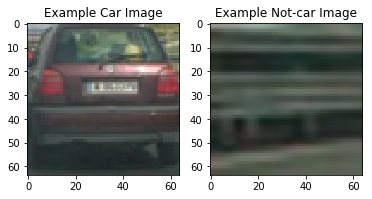

In [61]:
data_info = data_look(cars, not_cars)

print('Your dataset contains a count of', data_info["n_cars"], ' cars and', data_info["n_not_cars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(data_info['cars_sample'])
_ = plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(data_info['not_cars_sample'])
_ = plt.title('Example Not-car Image')

# This are the steps we need to accomplish:
    
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
### Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
### Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

In [62]:
# Parameters

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# HOG
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# Color
spatial_size = (32, 32)
hist_bins = 32

In [63]:
%%time

car_features = extract_features(cars, colorspace, spatial_size, hist_bins, \
                                orient,pix_per_cell, cell_per_block, hog_channel, \
                                spatial_feat=True, hist_feat=True, hog_feat=True)


not_car_features = extract_features(not_cars, colorspace, spatial_size, hist_bins, \
                                orient,pix_per_cell, cell_per_block, hog_channel, \
                                spatial_feat=True, hist_feat=True, hog_feat=True)

CPU times: user 38.4 s, sys: 340 ms, total: 38.7 s
Wall time: 38.8 s


In [69]:
# Create an array stack of feature vectors
X = np.vstack((car_features, not_car_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


In [70]:
# Use a linear SVC 
svc = LinearSVC()

In [71]:
%%time
svc.fit(X_train, y_train)

CPU times: user 13.1 s, sys: 224 ms, total: 13.3 s
Wall time: 13.3 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [72]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00148 Seconds to predict 10 labels with SVC


In [73]:
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))

Train Accuracy of SVC =  1.0


In [75]:
# Done!! Time to save the model

model = {'svc': svc, 'scaler': X_scaler}
pickle.dump(model, open(path2model, 'wb'))

### Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [4]:
# Load again those saved files

model = pickle.load(open(path2model, 'rb'))
svc = model['svc']
X_scaler = model['scaler']

In [5]:
# Parameters

colorspace = 'RGB2YCrCb' # Can be RGB2YCrCb, BGR2YCrCb, RGB2LUV

# HOG
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# Color
spatial_size = (32, 32)
hist_bins = 32

# Sliding-window
ystart = 400
ystop = 680
#scale = 1.5
scale = 1

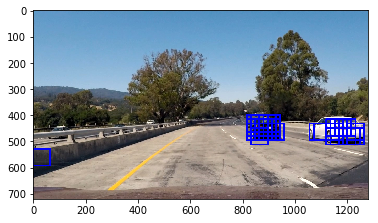

In [6]:
img = cv2.imread(test_images[1])[:,:,::-1]

bbox_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, \
          orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

_ = plt.imshow(bbox_img)

0
30
26
28
1
33


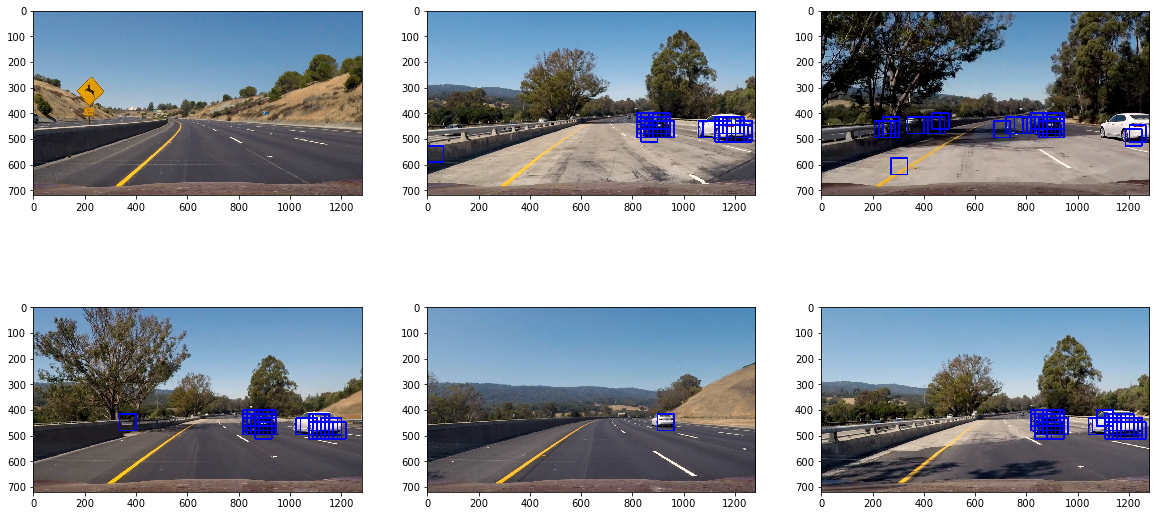

In [130]:
plt.figure(1, figsize=(20, 10))

i = 1

for image_name in test_images:
    img = cv2.imread(image_name)[:,:,::-1]
    plt.subplot(2,3, i)
    bbox_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, \
          orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    print(len(bbox))
    plt.imshow(bbox_img)
    i += 1

### Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [14]:
# The strategy here is to always have buffer_size images loaded in memory. 
# With that buffer, we will be able to reject false positives.
# Detected cars will be stored as a list of bounding box coordinates.
# Detections for all frames will be stored in memory as a list.
# After reading the whole video once, it will be called a second time just to draw the survivla boxes


def video_detection_temporal_smoothing(buffer_size, threshold, clip_name, debug=False):
    
    clip = VideoFileClip(clip_name) 
    iter_frame = clip.iter_frames()
    total_frames = int(clip.fps * clip.duration)

    print("Video: %s has a total of %d frames" % (clip_name, total_frames))

    video_bounding_boxes = list()
    buffer = list()
    count = 1

    if debug:
        ls_heatmap = list()
        ls_frames = list()

    # Initial warmup
    for a in range(0,buffer_size):
        img = next(iter_frame)
        bbox_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, \
              orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

        if debug:
            heatmap = np.zeros(img.shape[:2])
            heatmap = add_heat(heatmap, bbox)

            ls_heatmap.append(heatmap)
            ls_frames.append(bbox_img)
            
        buffer.append(bbox)

    # Starting frame-by-frame analysis
    ind = 0

    for a in tqdm(range(0, total_frames-buffer_size)):

        #if (a + buffer_size) % 20 == 0:
        #    print("    Frames processed: %d/%d" %(a+buffer_size, total_frames))
            
        # Process first frame indexed by ind
        heatmap = np.zeros(img.shape[:2])

        for bbox_list in buffer:
            heatmap = add_heat(heatmap, bbox_list)

        th_heatmap = apply_threshold(heatmap, threshold)
        labels = label(th_heatmap)
        frame_bounding_boxes = compute_labeled_bboxes(labels)
        # Filters
        frame_bounding_boxes = area_filter(frame_bounding_boxes)
        frame_bounding_boxes = aspect_ratio_filter(frame_bounding_boxes)
        
        video_bounding_boxes.append(frame_bounding_boxes)

        # Substitute that frame with the new one
        # Advance the index and repeat
        img = next(iter_frame)
        
        _, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, \
              orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
        
        buffer[ind] = bbox
        ind = (ind +1) % buffer_size
        
        if debug:
            if a == 2:
                break

    print("Done!!")
    
    if debug:
        return video_bounding_boxes, ls_frames, ls_heatmap
    else:
        return video_bounding_boxes

In [179]:
buffer_size = 6 # Number of images compared to reject false positives
threshold = 2
clip_name = 'test_video.mp4'

video_bounding_boxes, ls_frames, ls_heatmap = \
    video_detection_temporal_smoothing(buffer_size, threshold, clip_name, debug=True)

Video: test_video.mp4 has a total of 38 frames


  6%|▋         | 2/32 [00:01<00:26,  1.14it/s]

Done!!


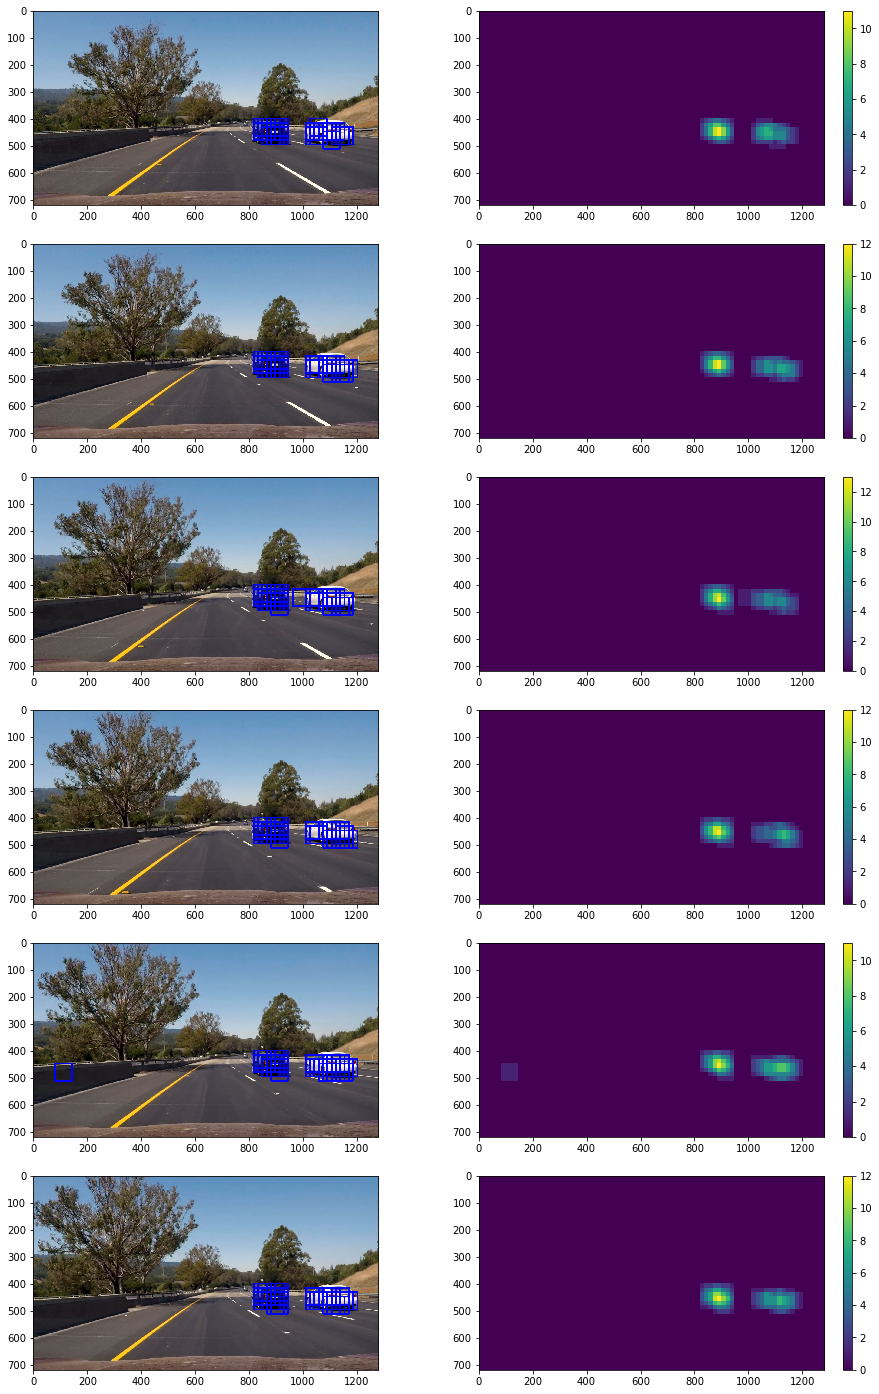

In [180]:
plt.figure(1, figsize=(15, 25))

i = 1
n = len(ls_heatmap)

for frame, heatmap in zip(ls_frames, ls_heatmap): # This is Python3, zip returns an iterator
    
    plt.subplot(n,2, i)
    plt.imshow(frame)
    i += 1
    
    plt.subplot(n,2, i)
    plt.imshow(heatmap)
    _ = plt.colorbar(fraction=0.026) # Parameter figured out empirically
    i += 1

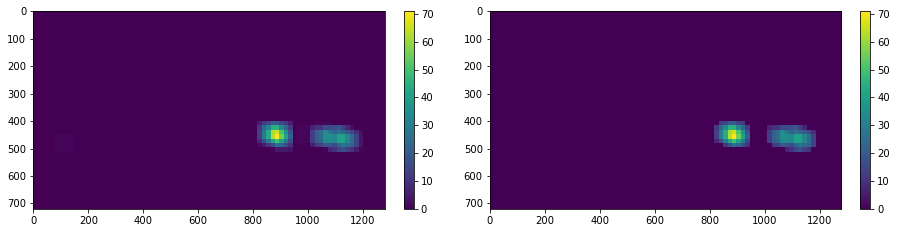

In [181]:
# Combined heatmap
combined_heatmap = sum(ls_heatmap)

def combined_thresholding_slider(threshold):
    combined_heatmap_copy = np.copy(combined_heatmap)
    th_heatmap = apply_threshold(combined_heatmap_copy, threshold)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(combined_heatmap)
    _ = plt.colorbar(fraction=0.026)
    
    plt.subplot(1,2,2)
    plt.imshow(th_heatmap)
    _ = plt.colorbar(fraction=0.026)
    
_ = ipywidgets.interact(combined_thresholding_slider, threshold=(0, 35, 1))

After some tests, a good combination seems to be:
```python
buffer_size = 6
threshold = buffer_size
```

**Full video processing: test_video.mp4**

In [182]:
# Let's go for the final result

buffer_size = 6 # Number of images compared to reject false positives
threshold = buffer_size
clip_name = 'test_video.mp4'

video_bounding_boxes = video_detection_temporal_smoothing(buffer_size, threshold, clip_name)

Video: test_video.mp4 has a total of 38 frames


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

Done!!


In [183]:
len(video_bounding_boxes)

32

As final frames will not have detections in a small fraction of frames at the end of the video (equal to buffer_size) because of temporal smoothing, we can assume that, if the frame rate is high enough and the buffer size is small enough we can copy the detections from the last available image and use them in the final frames.

In [184]:
video_bounding_boxes += [video_bounding_boxes[-1]]*buffer_size
len(video_bounding_boxes)

38

In [185]:
iter_bboxes = iter(video_bounding_boxes)

def decorated_draw_bboxes(img):
    bboxes = next(iter_bboxes)
    return draw_bboxes(img, bboxes)

In [148]:
clip = VideoFileClip(clip_name)
processed = clip.fl_image(decorated_draw_bboxes)
processed.write_videofile(clip_name.replace(".mp4", "_processed.mp4"), audio=False, threads=2)

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4


 95%|█████████▍| 37/39 [00:00<00:00, 96.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 



In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_name.replace(".mp4", "_processed.mp4")))

**Full video processing: project_video.mp4**

In [15]:
# Let's go for the final result

buffer_size = 20 # Number of images compared to reject false positives
threshold = buffer_size
clip_name = 'project_video.mp4'

video_bounding_boxes = video_detection_temporal_smoothing(buffer_size, threshold, clip_name)
video_bounding_boxes += [video_bounding_boxes[-1]]*buffer_size

Video: project_video.mp4 has a total of 1260 frames


100%|██████████| 1240/1240 [18:47<00:00,  1.10it/s]

Done!!


In [16]:
iter_bboxes = iter(video_bounding_boxes)

def decorated_draw_bboxes(img):
    bboxes = next(iter_bboxes)
    return draw_bboxes(img, bboxes)

In [17]:
clip = VideoFileClip(clip_name)
processed = clip.fl_image(decorated_draw_bboxes)
processed.write_videofile(clip_name.replace(".mp4", "_processed.mp4"), audio=False, threads=2)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1259/1261 [01:01<00:00, 20.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 



In [ ]:
!mv project_video_processed.mp4 project_video_processed_area_ar_filter.mp4 

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_name.replace(".mp4", "_processed_area_ar_filter.mp4")))

### Extra section: post-processing filters

Note: the conclusions extracted in this section were later applied in ``video_detection_temporal_smoothing()``.

Still there are more false positives than I wanted, so a good idea could be filter out those detections with a tiny area. 

In [210]:
def area (frames):
    
    frame_areas = list()
    areas = list()
    
    for bboxes in frames:
        
        #areas = list()
        
        for bbox in bboxes:
            tl, br = bbox
            tmp = (br[0]-tl[0])*(br[1]-tl[1])
            areas.append(tmp)
            
        #frame_areas.append(areas)
        
    #return frame_areas
    return areas

In [213]:
total_areas = area(video_bounding_boxes)

<Container object of 3 artists>

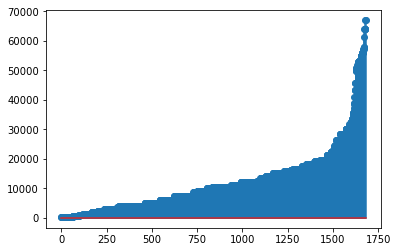

In [216]:
plt.stem(sorted(total_areas))

Also, after some exploration, I reach the conclusion that many false positives included an aspect ratio (relation between width and height) that is impossible for a car. Let's visualize aspect ratio distribution:

In [218]:
def aspect_ratio (frames):
    
    frame_areas = list()
    areas = list()
    
    for bboxes in frames:
        
        #areas = list()
        
        for bbox in bboxes:
            tl, br = bbox
            tmp = (br[0]-tl[0])/(br[1]-tl[1])
            areas.append(tmp)
            
        #frame_areas.append(areas)
        
    #return frame_areas
    return areas

In [219]:
total_aspect_ratio = aspect_ratio(video_bounding_boxes)

<Container object of 3 artists>

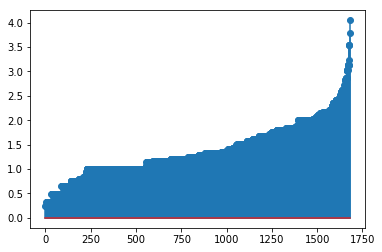

In [220]:
plt.stem(sorted(total_aspect_ratio))